In [1]:
import numpy as np
import scipy 
import skbio
import pandas as pd
import os
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Calculate alpha diversity 


## Calculate alpha diversity using species abundance produced by metaphlan2

In [2]:
#load metaphlan2 species abundance

df_species=pd.read_csv('./data/metaphlan2_species_level_abundance_classified.csv',index_col=0)
df_species=df_species.fillna(value=0)

#load the species abundance profile with species name abundance replaced by taxonID
# This is to ensure the consistency between phylo tree and abundance profile
df_spe_taxID=pd.read_csv('./data/metaphlan2_species_abundance_taxonID.csv',index_col=0)
df_spe_taxID=df_spe_taxID.fillna(value=0)


In [3]:
##load metadata 
df_meta=pd.read_csv('./data/metadata_updated_filtered_201904.csv',index_col=0)
df_meta=df_meta.fillna(value=100)

#create dictionary that stores patients information
dic_subtype=dict(zip(df_meta.index,df_meta.disease))
dic_surgery=dict(zip(df_meta.index,df_meta.surgery_type))
dic_complication=dict(zip(df_meta.index, df_meta.crohns_disease_behavior))

### Separate samples by surgery type

In [4]:
## split the patients into UC, CD and with/without surgery group 
colectomy=[]
ilealcolonic=[]
sugery_none=[]

for i in df_species.columns: 
    if i in dic_subtype.keys(): 
        if dic_surgery[i]=='colectomy' or dic_surgery[i]=='partial_colectomy': 
            colectomy.append(i)
        elif dic_surgery[i]=='none': 
            sugery_none.append(i)
        else: 
            ilealcolonic.append(i)
            
print ('Number of samples in colectomy group: ', len(colectomy))
print ('Number of samples in ilealcolonic group: ',len(ilealcolonic))
print ('Number of samples in no surgery group: ',len(sugery_none))


Number of samples in colectomy group:  51
Number of samples in ilealcolonic group:  41
Number of samples in no surgery group:  209


## alpha diversity for non-phylogenetic metrics

In [5]:
from skbio.diversity import alpha_diversity

#preprocess data - alpha diversity function only takes in integers
df=df_species.transpose()
data_pre=100000*pd.DataFrame.as_matrix(df_species.transpose())
data=data_pre.astype(int)
ids=df.index

#observed OTU
adiv_otus = alpha_diversity('observed_otus', data, ids)
print ('Mean alpha diversity of all samples (observed OTU): ' )
print (str(np.mean(list(adiv_otus.data))))

#shannon
adiv_shannon = alpha_diversity('shannon', data, ids)
print ('Mean alpha diversity of all samples (shannon): ' )
print (str(np.mean(list(adiv_shannon.data))))


Mean alpha diversity of all samples (observed OTU): 
54.42857142857143
Mean alpha diversity of all samples (shannon): 
3.204316663073162


## Alpha diversity with phylogenetic metric: Faith

In [6]:
from skbio import TreeNode
from io import StringIO

# load phylogenetic tree built in the preprocessing notebook
with open('./data/phylotree_sandborn.nw', 'r') as myfile:
    data=myfile.read()
tree=TreeNode.read(StringIO(data))
otuid=[str(i) for i in df.columns]


#preprocess data - alpha diversity function only takes in integers
df=df_spe_taxID.transpose()
data_pre=100000*pd.DataFrame.as_matrix(df_spe_taxID.transpose())
data=data_pre.astype(int)
ids=df.index
otuid=[str(i) for i in df.columns]

adiv_faith = alpha_diversity('faith_pd', data,ids=list(ids),otu_ids=otuid, tree=tree)
print ('Mean alpha diversity of all samples (Faith): ' )
print (str(np.mean(list(adiv_faith.data))))

## save alpha diversity into a csv file 
#adiv_faith.to_csv('../data/Sandborn_data/metadata/Alpha_diversity_faith.csv')

Mean alpha diversity of all samples (Faith): 
107.28571428571429


In [7]:
# extract faith diversity for subgroups separated by surgery subtype
df_alpha_colectomy=adiv_faith.loc[colectomy]
df_alpha_ilealcolonic=adiv_faith.loc[ilealcolonic]
df_alpha_no=adiv_faith.loc[sugery_none]

print ('Mean alpha diversity of no surgery samples (Faith): ' )
print (str(np.mean(list(df_alpha_no.data))))
print ('Mean alpha diversity of ilealcolonic samples (Faith): ' )
print (str(np.mean(list(df_alpha_ilealcolonic.data))))
print ('Mean alpha diversity of colectomy samples (Faith): ' )
print (str(np.mean(list(df_alpha_colectomy.data))))


Mean alpha diversity of no surgery samples (Faith): 
117.00478468899522
Mean alpha diversity of ilealcolonic samples (Faith): 
93.48780487804878
Mean alpha diversity of colectomy samples (Faith): 
78.54901960784314


/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0,0.5,'alpha diversity (Faith)')

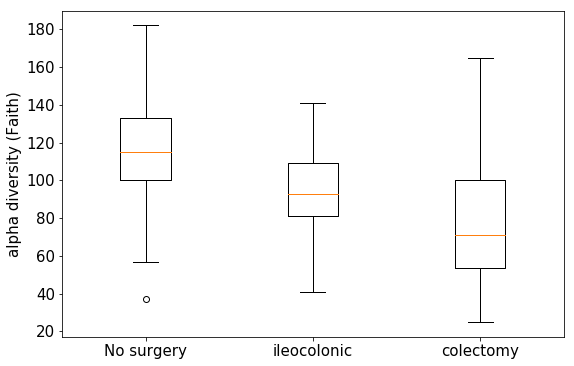

In [8]:
## plot faith alpha diversity for these  different groups 

import matplotlib
from matplotlib import pyplot as plt 

data_to_plot=[df_alpha_no,df_alpha_ilealcolonic, df_alpha_colectomy]
matplotlib.rcParams.update({'font.size': 15})

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp=ax.boxplot(data_to_plot) 
ax.set_xticklabels(['No surgery', 'ileocolonic', 'colectomy'])
ax.set_ylabel('alpha diversity (Faith)')
#fig.savefig('../data/Sandborn_data/figures/alpha_diversity_of_surgery_subgroups_faith.svg')

In [9]:
## Test the the statistical significance between 3 subgroups 

from scipy.stats import kruskal
print (kruskal(df_alpha_no,df_alpha_ilealcolonic,df_alpha_colectomy))

KruskalResult(statistic=69.76463826512718, pvalue=7.092531686809435e-16)


### Split in subgroups by complications to control  for disease severity

In [10]:
# look at only patients with stricturing and fistulizing complications 
# look at time in two groups- surgery vs non-surgery
complication_nosurgery=[]
complication_colectomy=[]
complication_ielocolonic=[]

nocomplication_nosurgery=[]
nocomplication_colectomy=[]
nocomplication_ielocolonic=[]

for i in df_spe_taxID: 
    if dic_complication[i]=='fistulizing' or dic_complication[i]== 'stricturing': 
        if dic_surgery[i]=='none': 
            complication_nosurgery.append(i)
        elif dic_surgery[i]=='colectomy'or dic_surgery[i]=='partial_colectomy': 
            complication_colectomy.append(i)
        else: 
            complication_ielocolonic.append(i)
    else: 
        if dic_surgery[i]=='none': 
            nocomplication_nosurgery.append(i)
        elif dic_surgery[i]=='colectomy' or dic_surgery[i]=='partial_colectomy': 
            nocomplication_colectomy.append(i)
        else: 
            nocomplication_ielocolonic.append(i)
        

# extract the alpha diversity 

alpha_comp_nosurg=adiv_faith.loc[complication_nosurgery]
alpha_comp_colec=adiv_faith.loc[complication_colectomy]
alpha_comp_ileo=adiv_faith.loc[complication_ielocolonic]
alpha_nocomp_nosurg=adiv_faith.loc[nocomplication_nosurgery]
alpha_nocomp_colec=adiv_faith.loc[nocomplication_colectomy]
alpha_nocomp_ileo=adiv_faith.loc[nocomplication_ielocolonic]

alpha_comp=adiv_faith.loc[complication_nosurgery+complication_colectomy+complication_ielocolonic]
alpha_nocomp=adiv_faith.loc[nocomplication_nosurgery+nocomplication_colectomy+nocomplication_ielocolonic]

In [11]:
#look at alpha diversity of subgroups 

print ('Mean alpha diversity of no surgery samples with complications (Faith): ' )
print (str(np.mean(list(alpha_comp_nosurg.data))))

print ('Mean alpha diversity of ilealcolonic samples with complications(Faith): ' )
print (str(np.mean(list(alpha_comp_ileo.data))))

print ('Mean alpha diversity of colectomy samples with complications(Faith): ' )
print (str(np.mean(list(alpha_comp_colec.data))))


Mean alpha diversity of no surgery samples with complications (Faith): 
103.83333333333333
Mean alpha diversity of ilealcolonic samples with complications(Faith): 
92.32
Mean alpha diversity of colectomy samples with complications(Faith): 
68.35714285714286


/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


(0.5, 6)

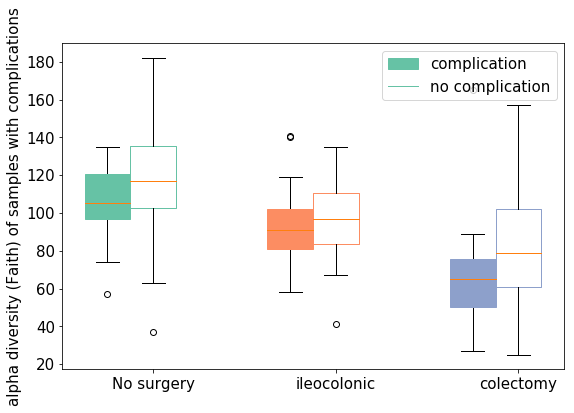

In [12]:
## plot faith alpha diversity for these  different groups 

import matplotlib
from matplotlib import pyplot as plt 

data_to_plot=[alpha_comp_nosurg,alpha_comp_ileo, alpha_comp_colec]
data_to_plot2=[alpha_nocomp_nosurg,alpha_nocomp_ileo, alpha_nocomp_colec]

matplotlib.rcParams.update({'font.size': 15})
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp1=ax.boxplot(data_to_plot,positions=[1,3,5], patch_artist=True) 
bp2=ax.boxplot(data_to_plot2,positions=[1.5,3.5,5.5]) 

# fill with colors
colors = ['#66c2a5', '#fc8d62', '#8da0cb']
for bplot in (bp1, bp2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_color(color)
    
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['complication', 'no complication'], loc='upper right')

ax.set_xticklabels(['No surgery', 'ileocolonic', 'colectomy'])
ax.set_ylabel('alpha diversity (Faith) of samples with complications')
ax.set_xlim(0.5,6)
#fig.savefig('../data/Sandborn_data/figures/alpha_diversity_of_surgery_subgroups_faith_complication.svg')
#fig.savefig('../data/Sandborn_data/figures/alpha_diversity_of_surgery_subgroups_faith_complication.pdf')

In [13]:
## Test the the statistical significance between samples with/without complication 

from scipy.stats import mannwhitneyu
print (mannwhitneyu(alpha_comp,alpha_nocomp))

MannwhitneyuResult(statistic=4050.0, pvalue=4.595546226741946e-07)


### Association of alpha diversity with surgery time

In [14]:
#extract time passed since surgery and alpha diversity for these samples 

from scipy.stats import spearmanr 
from scipy.stats import pearsonr

sample_surgery=[]
surgeryDate=[]

#calculate time passed since surgery 
for i in range(len(df_meta)): 
    row=df_meta.iloc[i]
    if row.name in df_spe_taxID.columns: 
        if row.year_recent_bowel_surgery!='not provided': 
            time=int(row.collection_timestamp)-int(row.year_recent_bowel_surgery)
            if time > 0: 
                surgeryDate.append(time)
                sample_surgery.append(row.name)
            elif time ==0 and row.weeks_from_surgery!='not applicable': 
                if int(row.weeks_from_surgery)>0: 
                    #print row.name
                    surgeryDate.append(time)
                    sample_surgery.append(row.name)
                
alpha_surgtime=adiv_faith.loc[sample_surgery]


# calculate correlation for time passed since surgery and alpha diversity 
print ('correlation between alpha diversity and surgery date: ')

corrS=spearmanr(surgeryDate,alpha_surgtime)
print (corrS)


correlation between alpha diversity and surgery date: 
SpearmanrResult(correlation=0.049492290494930966, pvalue=0.6394198723359449)


### Calculate correlation of alpha diversity with disease duration, bmi, and age baseline


In [15]:
#extract disease duration and alpha diversity for these samples 

sample_duration=[]
durationList=[]

#calculate time passed since surgery 
for i in range(len(df_meta)): 
    row=df_meta.iloc[i]
    if row.name in df_spe_taxID.columns: 
        if row.disease_duration!=100: 
                durationList.append(row.disease_duration)
                sample_duration.append(row.name)
                
alpha_duration=adiv_faith.loc[sample_duration]

# calculate correlation for time passed since surgery and alpha diversity 
print ('correlation between alpha diversity and disease duration: ')
corrS=spearmanr(durationList,alpha_duration)
print (corrS)

correlation between alpha diversity and disease duration: 
SpearmanrResult(correlation=-0.045920568148002765, pvalue=0.5666909461868834)


In [16]:
#extract bmi and alpha diversity for these samples 

sample_bmi=[]
bmiList=[]

for i in range(len(df_meta)): 
    row=df_meta.iloc[i]
    if row.name in df_spe_taxID.columns: 
        if row.BMI!='missing: not provided': 
                bmiList.append(float(row.BMI))
                sample_bmi.append(row.name)
                
alpha_bmi=adiv_faith.loc[sample_bmi]

# calculate correlation for time passed since surgery and alpha diversity 
print ('correlation between alpha diversity and BMI: ')
corrS=spearmanr(bmiList,alpha_bmi)
print (corrS)


correlation between alpha diversity and BMI: 
SpearmanrResult(correlation=0.1099079711806714, pvalue=0.07518864989211932)


In [17]:
#extract age and alpha diversity for these samples 
#calculate correlation for time passed since surgery and alpha diversity 
print ('correlation between alpha diversity and age at baseline: ')
corrS=spearmanr(df_meta.loc[df_spe_taxID.columns].age_baseline,adiv_faith)
print (corrS)


correlation between alpha diversity and age at baseline: 
SpearmanrResult(correlation=0.027230846632832678, pvalue=0.637955623190798)


### Explore the correlation of alpha diversity and smoking status between UC and CD subtypes

In [18]:
## first look at correlation with smoking status before spliting into subtypes 
sample_smoking=[]
smokeList=[]

for i in range(len(df_meta)): 
    row=df_meta.iloc[i]
    if row.name in df_spe_taxID.columns: 
        if row.smoking_status!=100: 
                smokeList.append(float(row.smoking_status))
                sample_smoking.append(row.name)
alpha_smoke=adiv_faith.loc[sample_smoking]

#correlation test 
never_all=[alpha_smoke.loc[i] for i in sample_smoking if df_meta.loc[i].smoking_status==0]
before_all=[alpha_smoke.loc[i] for i in sample_smoking if df_meta.loc[i].smoking_status==1]
current_all=[alpha_smoke.loc[i] for i in sample_smoking if df_meta.loc[i].smoking_status==2]
from scipy.stats import kruskal
kruskal(never_all,before_all,current_all)


KruskalResult(statistic=0.7515276693505926, pvalue=0.6867645038540338)

In [19]:
# look at disease substypes

cd_sample=[i for i in sample_smoking if df_meta.disease.loc[i]=='cd']
uc_sample=[i for i in sample_smoking if df_meta.disease.loc[i]=='uc']

#correlation test on cd samples 
never_cd=[alpha_smoke.loc[i] for i in cd_sample if df_meta.loc[i].smoking_status==0]
before_cd=[alpha_smoke.loc[i] for i in cd_sample if df_meta.loc[i].smoking_status==1]
current_cd=[alpha_smoke.loc[i] for i in cd_sample if df_meta.loc[i].smoking_status==2]
from scipy.stats import kruskal
kruskal(never_cd,before_cd,current_cd)

#correlation test on uc samples 
never_uc=[alpha_smoke.loc[i] for i in uc_sample if df_meta.loc[i].smoking_status==0]
before_uc=[alpha_smoke.loc[i] for i in uc_sample if df_meta.loc[i].smoking_status==1]
current_uc=[alpha_smoke.loc[i] for i in uc_sample if df_meta.loc[i].smoking_status==2]
from scipy.stats import kruskal
kruskal(never_uc,before_uc,current_uc)

KruskalResult(statistic=5.14416881997107, pvalue=0.07637618011779962)

### Association of alpha diversity with E.coli abundance

In [20]:
#extract ecoli abundance 

ecoli_abund=df_spe_taxID.T[1005520]
corrS=spearmanr(ecoli_abund,adiv_faith)
print (corrS)

SpearmanrResult(correlation=-0.25666423895850665, pvalue=6.4763322990815385e-06)


y=-0.685208x+(113.760405)


Text(0,0.5,'Alpha Diversity (Faith)')

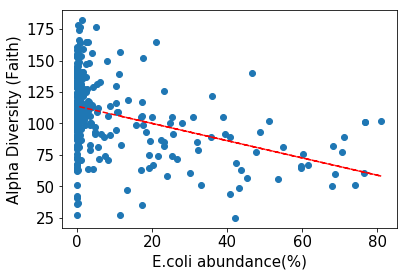

In [21]:
plt.scatter(ecoli_abund,adiv_faith)

# calc the trendline
x=ecoli_abund
z = np.polyfit(ecoli_abund, adiv_faith, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

plt.xlabel('E.coli abundance(%)')
plt.ylabel('Alpha Diversity (Faith)')


## Calculate alpha diversity of pathway abundance generated from humann2

In [22]:
#load pathway abundance

df_pathway=pd.read_csv('./data/Filtered_normalized_cpm_pathways_new_unstratified.csv',index_col=0)
df_pathway=df_pathway.fillna(value=0)

## split the patients into UC, CD and with/without surgery group 
colectomy_pw=[]
ilealcolonic_pw=[]
sugery_none_pw=[]

for i in df_pathway.columns: 
    if i in dic_subtype.keys(): 
        if dic_surgery[i]=='colectomy' or dic_surgery[i]=='partial_colectomy': 
            colectomy_pw.append(i)
        elif dic_surgery[i]=='none': 
            sugery_none_pw.append(i)
        else: 
            ilealcolonic_pw.append(i)

## Alpha diversity for non-phylogenetic metrics for functional profiles

In [23]:
from skbio.diversity import alpha_diversity

#preprocess data - alpha diversity function only takes in integers

df=df_pathway.transpose()
data_pre=100000*pd.DataFrame.as_matrix(df)
data=data_pre.astype(int)
ids=df.index

#observed OTU
adiv_otus_pw = alpha_diversity('observed_otus', data, ids)
print ('Mean alpha diversity of functional profiles (observed OTU): ' )
print (str(np.mean(list(adiv_otus_pw.data))))

#shannon
adiv_shannon_pw = alpha_diversity('shannon', data, ids)
print ('Mean alpha diversity of functional profiles (shannon): ' )
print (str(np.mean(list(adiv_shannon_pw.data))))


Mean alpha diversity of functional profiles (observed OTU): 
308.46
Mean alpha diversity of functional profiles (shannon): 
7.302150253204357


In [24]:
# extract faith diversity for subgroups separated by surgery subtype
df_alpha_colectomy_pw=adiv_shannon_pw.loc[colectomy_pw]
df_alpha_ilealcolonic_pw=adiv_shannon_pw.loc[ilealcolonic_pw]
df_alpha_no_pw=adiv_shannon_pw.loc[sugery_none_pw]

print ('Mean alpha diversity of no surgery samples(pathway;shannon): ' )
print (str(np.mean(list(df_alpha_no_pw.data))))
print ('Mean alpha diversity of ilealcolonic samples (pathway;shannon): ' )
print (str(np.mean(list(df_alpha_ilealcolonic_pw.data))))
print ('Mean alpha diversity of colectomy samples (pathway;shannon): ' )
print (str(np.mean(list(df_alpha_colectomy_pw.data))))

Mean alpha diversity of no surgery samples(pathway;shannon): 
7.21770445620894
Mean alpha diversity of ilealcolonic samples (pathway;shannon): 
7.415795219214607
Mean alpha diversity of colectomy samples (pathway;shannon): 
7.555195001608801
